# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype


steps to train a DNN¶
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


In [2]:
import pandas as pd
import numpy as np


In [3]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [4]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [5]:
len(city_data)

3592

In [6]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
1315,2741586,11821,34.965323,-120.574576,Guadalupe,7080,CA,C
2218,6710994,0,35.539122,-87.206639,Mount Pleasant,3507,TN,C
1017,16815084,117653,36.143489,-82.409338,Erwin,9788,TN,C
1122,4793595,47682,38.241084,-87.580323,Fort Branch,4379,IN,C
2896,198729334,185800,34.429887,-118.521858,Santa Clarita,258653,CA,U


In [7]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)

In [8]:
#normalise data
train, validation, test = (0.6,0.2,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 2.74158600e+06  1.18210000e+04  3.49653230e+01 -1.20574576e+02]


In [9]:
#encode data
states = to_one_hot(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [10]:
numeric_data.shape

(3592, 158)

In [11]:
#split data
train_f, validation_f, test_f = (0.7,0.2,0.1)
train = int(train_f*len(numeric_data))
validation = int((train_f+validation_f)*len(numeric_data))
print(validation)
x_train,x_validate,x_test = (numeric_data[:train],numeric_data[train:(validation)],numeric_data[validation:])
y_train,y_validate,y_test = (population[:train],population[train:(validation)],population[validation:])

3232


In [12]:
x_train.shape,x_validate.shape,x_test.shape

((2514, 158), (718, 158), (360, 158))

In [13]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics

def createmodel(nodes):
    model = Sequential()
    model.add(layers.Dense(nodes[0],activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    
    model.compile(optimizer='rmsprop',loss=['mape'],metrics=['mae'])
    return model

Using TensorFlow backend.


In [14]:
import matplotlib.pyplot as pp
%matplotlib inline
def plothistory(history):
    pp.figure(figsize=(14,4))
    pp.subplot(1,2,1)
    pp.plot(history.history['loss'],label='Training loss')
    pp.plot(history.history['val_loss'],label='Validation loss')
    pp.xlabel('epochs')
    pp.ylabel('loss')
    pp.legend()
    pp.title('Loss vs epoch')
    
    pp.subplot(1,2,2)
    pp.plot(history.history['mean_absolute_error'],label='mean absolute error')
    pp.plot(history.history['val_mean_absolute_error'],label='validation mean absolute error')
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()
    pp.title('Mean absolute error vs epoch')

In [15]:
model = createmodel([32,16,16,16])
history = model.fit(x_train,y_train,
         validation_data=(x_validate,y_validate),
         epochs=120,
         batch_size = 50)

Train on 2514 samples, validate on 718 samples
Epoch 1/120
2514/2514 [==============================] - 1s 199us/step - loss: 90.2686 - mean_absolute_error: 73.7563 - val_loss: 70.7872 - val_mean_absolute_error: 64.2503
Epoch 2/120
2514/2514 [==============================] - 0s 49us/step - loss: 55.8479 - mean_absolute_error: 71.4623 - val_loss: 51.1001 - val_mean_absolute_error: 62.6403
Epoch 3/120
2514/2514 [==============================] - 0s 46us/step - loss: 51.6922 - mean_absolute_error: 70.9485 - val_loss: 50.8097 - val_mean_absolute_error: 62.6199
Epoch 4/120
2514/2514 [==============================] - 0s 52us/step - loss: 51.3938 - mean_absolute_error: 70.8517 - val_loss: 50.6191 - val_mean_absolute_error: 62.5208
Epoch 5/120
2514/2514 [==============================] - 0s 61us/step - loss: 51.1519 - mean_absolute_error: 70.7534 - val_loss: 50.4285 - val_mean_absolute_error: 62.3881
Epoch 6/120
2514/2514 [==============================] - 0s 46us/step - loss: 50.9251 - mean

2514/2514 [==============================] - 0s 61us/step - loss: 29.7098 - mean_absolute_error: 42.1047 - val_loss: 32.2663 - val_mean_absolute_error: 35.4419
Epoch 49/120
2514/2514 [==============================] - 0s 46us/step - loss: 28.8050 - mean_absolute_error: 41.2449 - val_loss: 37.5136 - val_mean_absolute_error: 34.5354
Epoch 50/120
2514/2514 [==============================] - 0s 49us/step - loss: 28.7102 - mean_absolute_error: 40.4309 - val_loss: 34.4251 - val_mean_absolute_error: 35.4003
Epoch 51/120
2514/2514 [==============================] - 0s 40us/step - loss: 28.1587 - mean_absolute_error: 39.9113 - val_loss: 32.0198 - val_mean_absolute_error: 34.1384
Epoch 52/120
2514/2514 [==============================] - 0s 52us/step - loss: 27.7099 - mean_absolute_error: 39.3073 - val_loss: 36.8925 - val_mean_absolute_error: 32.4189
Epoch 53/120
2514/2514 [==============================] - 0s 46us/step - loss: 27.1812 - mean_absolute_error: 38.2985 - val_loss: 33.2100 - val_mean

2514/2514 [==============================] - 0s 61us/step - loss: 23.1062 - mean_absolute_error: 29.4303 - val_loss: 26.1181 - val_mean_absolute_error: 25.0861
Epoch 96/120
2514/2514 [==============================] - 0s 52us/step - loss: 22.8423 - mean_absolute_error: 29.1853 - val_loss: 27.0401 - val_mean_absolute_error: 25.1285
Epoch 97/120
2514/2514 [==============================] - 0s 46us/step - loss: 22.8609 - mean_absolute_error: 29.1121 - val_loss: 26.4713 - val_mean_absolute_error: 24.4512
Epoch 98/120
2514/2514 [==============================] - 0s 52us/step - loss: 23.0382 - mean_absolute_error: 28.9420 - val_loss: 27.8657 - val_mean_absolute_error: 24.6895
Epoch 99/120
2514/2514 [==============================] - 0s 34us/step - loss: 22.8536 - mean_absolute_error: 29.0898 - val_loss: 30.2598 - val_mean_absolute_error: 24.5075
Epoch 100/120
2514/2514 [==============================] - 0s 79us/step - loss: 22.9143 - mean_absolute_error: 28.9285 - val_loss: 30.1018 - val_mea

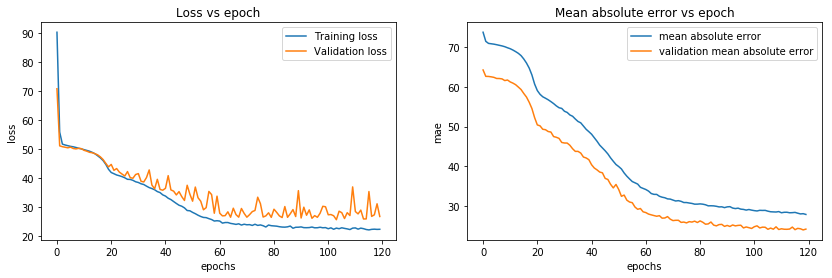

In [20]:
plothistory(history)

In [21]:
def seepredictions(model):
    df_validation = df.loc[df.index[range(train,validation)]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_validate)*1000
    df_validation['Predictions']=pred
    df_validation['DiffPercentage']=abs(df_validation['Predictions']-df_validation['POP10'])/df_validation['POP10']*100
    return df_validation

In [22]:
print('mean percentage diff = ', seepredictions(model)['DiffPercentage'].mean())
val_df = seepredictions(model)
val_df.head()

mean percentage diff =  26.746609938835295


,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
1510,22896208,293165,26.422586,-81.438025,Immokalee,23160,FL,C,8345.776367,63.964696
229,17378363,29441,37.338355,-79.525928,Bedford,6829,VA,C,7517.917480,10.088117
1136,183291657,2558528,35.307922,-94.413604,Fort Smith,122947,AR--OK,U,70944.968750,42.296299
3262,8037849,492788,38.275131,-78.438898,Twin Lakes,3191,VA,C,3542.553223,11.017024
3535,3191976,0,48.092179,-105.641894,Wolf Point,3540,MT,C,3513.464111,0.749601


In [23]:
#analyze
l = len(val_df)
val_df.sort_values('Predictions').head(500).tail(10)

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
203,21341285,0,34.304050,-89.942143,Batesville,7309,MS,C,10481.194336,43.401209
1775,25056976,0,35.608289,-105.223373,Las Vegas,15609,NM,C,10486.770508,32.815872
2513,23107623,1348839,32.372404,-97.663569,Pecan Plantation,6366,TX,C,10535.705078,65.499609
2791,16396037,35900,34.862342,-118.180373,Rosamond,16000,CA,C,10580.379883,33.872626
2102,18180704,85244,46.403204,-105.835006,Miles City,9604,MT,C,10600.586914,10.376790
2997,26343401,49367,32.780661,-108.266686,Silver City,12705,NM,C,10606.975586,16.513376
2421,16289234,98622,42.873546,-89.364865,Oregon,11059,WI,C,10702.421875,3.224325
1023,19404083,49052,40.363508,-105.518915,Estes Park,7082,CO,C,10705.447266,51.164181
1513,14750386,22980,37.229062,-95.714514,Independence,9959,KS,C,10782.252930,8.266422
3316,21838549,2997704,38.199622,-92.705429,Village of Four Seasons,4451,MO,C,10899.663086,144.881220


In [24]:
#evaluate
model.evaluate(x_test,y_test)

360/360 [==============================] - 0s 43us/step


[25.428543768988714, 14.12850947909885]